# 5. Clustering

From the previously-obtained features, we can now cluster the data. We will use
the K-means algorithm, which is a simple and efficient algorithm for clustering.
Depending on the task at hand, other algorithms may be more appropriate. Please
follow the [scikit-learn
documentation](https://scikit-learn.org/stable/modules/clustering.html)
for more information. 

Note that we use directly the features extracted with the inependent component
analysis (ICA) as input for the clustering algorithm. This is not mandatory, and
you can use the features extracted with the scattering network instead. We 
here opt for the ICA features because they lie in a lower-dimensional space,
which makes the clustering algorithm more efficient (see the comments on the 
curse of dimensionality).

Made in 2022 by Léonard Seydoux and René Steinmann.

In [37]:
import matplotlib.pylab as plt
import numpy as np
import obspy
from sklearn.cluster import KMeans

plt.rcParams["date.converter"] = "concise"

## Load features

We first load the features calculated in the notebook
`3_dimensionality_reduction.ipynb`. We will use the features extracted with the
independent component analysis (ICA) as input for the clustering algorithm.

In [3]:
# Load data from file
with np.load("../example/independent_components.npz", allow_pickle=True) as data:
    features = data["features"]
    times = data["times"]

## $k$-means clustering

We now perform the clustering. We will use the $k$-means algorithm, which is a
simple and efficient algorithm for clustering. Depending on the task at hand,
other algorithms may be more appropriate. Please follow the [scikit-learn
documentation](https://scikit-learn.org/stable/modules/clustering.html)
for more information.

The $k$-means algorithm solves the following optimization problem:

$$ \min_{\mathbf{C}, \mathbf{Z}} \sum_{i=1}^N \sum_{k=1}^K z_{ik} \| \mathbf{x}_i - \mathbf{c}_k \|^2 $$

where $\mathbf{C} = \{\mathbf{c}_1, \ldots, \mathbf{c}_K\}$ is the set of
cluster centers, $\mathbf{Z} = \{z_{1}, \ldots, z_{N}\}$ is the set of
assignment vectors, and $z_{ik} = 1$ if $\mathbf{x}_i$ is assigned to cluster
$k$, and $z_{ik} = 0$ otherwise. The assignment vectors are also called
responsibilities.

The $k$-means algorithm requires the number of clusters as input. Several
methods exist to determine this number. Here, we will define this number 
manually, and allow the user to change it. Depending on the application, 
we chose the number of clusters differently. 

### Optimize model

In [31]:
number_of_clusters = 10

# Perform clustering
model = KMeans(n_clusters=number_of_clusters, n_init="auto")
model.fit(features)

# Predict cluster for each sample
predictions = model.predict(features)

### Vizualize cluster-wise detection rate

A way to vizualize the clustering results is to plot the cluster-wise detection
rate as a function of the cluster number. This is done by computing the
detection curve for each cluster, and then averaging the results in a sliding
window. 

The detection rate of a given cluster is given by the one-hot encoding of the
cluster label as a function of time. One can smooth the detection rate by
cluster by convolving it with a Gaussian kernel or a boxcar window (running average).

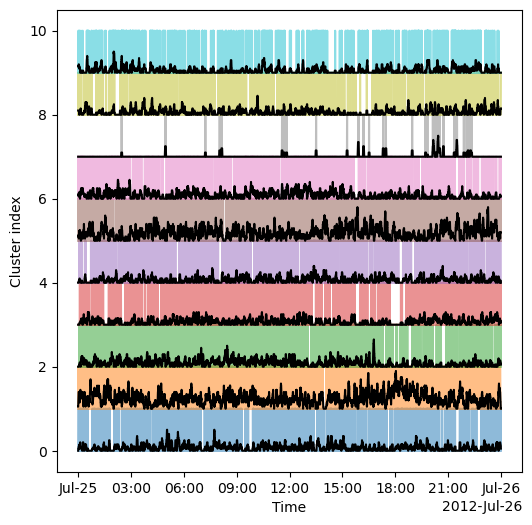

In [34]:
SMOOTH_KERNEL = 20

# Convert predictions to one-hot encoding
one_hot = np.zeros((len(times), number_of_clusters + 1))
one_hot[np.arange(len(times)), predictions] = 1

# Plot the results
fig, ax = plt.subplots(figsize=(6, 6))

# Plot each cluster as a separate line
for i in range(number_of_clusters):

    # Obtain the detection rate by convolving with a boxcar kernel
    detection_rate = np.convolve(one_hot[:, i], np.ones(SMOOTH_KERNEL), mode="same") / SMOOTH_KERNEL

    # Plot the detection rate
    ax.plot(times, one_hot[:, i] + i, alpha=0.5)
    ax.plot(times, detection_rate + i, color="black")

ax.set_xlabel("Time")
ax.set_ylabel("Cluster index")

plt.show()

## Extract corresponding waveforms

Another way of vizualizing the clustering results is to extract the waveforms
corresponding to each cluster. We can then plot the most $N$ representative
waveforms for each cluster.

In [38]:
stream = obspy.read("../example/scattering_stream.mseed")

# Extract waveforms
waveforms = list()
for cluster in np.unique(predictions):

    # Calculate the mean of the cluster
    mean = np.mean(features[predictions == i], axis=0)

    # Distance of each sample to the mean
    distance = np.linalg.norm(features[predictions == i] - mean, axis=1)

    # Get times of the closest samples
    closest = times[predictions == i][distance.argsort()[:5]]

    # Collect waveforms in a list
    traces = list()
    for time in closest:
        time = obspy.UTCDateTime(time)
        traces.append(stream.slice(time - 5, time + 5).copy())
    waveforms.append(traces)

# Plot the results
fig, ax = plt.subplots(number_of_clusters, figsize=(10, 6))

# Plot each cluster as a separate line
for i, traces in enumerate(waveforms):

    # Plot the detection rate
    for trace in traces:
        ax[i].plot(trace.times(), trace.data)
    ax[i].set_title(f"Cluster {i}")

FileNotFoundError: [Errno 2] No such file or directory: '../example/scattering_stream.mseed'